# Neural Networks


## Names of group members (max 2):
    
    Kevin Vonk


Neural networks (NN) are essentially the closest we've come to universal function approximators. All the hype you've been hearing about Deep Learning and "AI" are due to advances in NNs. These beasts deserve a separate course, but here you'll get to learn how a basic NN works

If you recall logistic regression, we model a classification problem as a non-linear function of the input vector.
When the problem in question is quite complicated, and the number of possible input features are large, simple classification, regression or classic ML techniques have limited ability. Composing functions of functions, say $f( g( h(X,W_{0}),W_{1}),W_{2}) $ would be better equipped to 'learn' more complicated functions. 

NNs are effectively compositions of functions consisting of layers of 'nodes'. The permuted connections between these nodes allow complex 'functions' to be 'learnt'. Depicted below is a 3-layer NN, consisting of an input layer, a 'hidden' layer and an output layer.

Why provide an elaborate explanation when this beautiful visualization exists:
https://www.youtube.com/watch?v=aircAruvnKk ?

If the following 2 code blocks throw an error, it is because you are missing "nn.png" and "nnlogic.png" files which you can download from canvas.

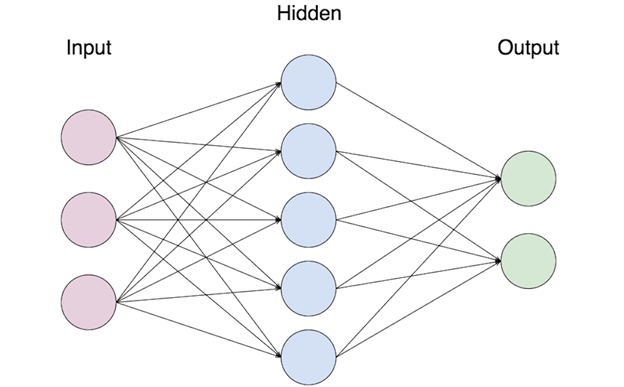

In [1]:
from IPython.display import Image
Image("../data/nn.png")

### To start off, let's first visualise logistic regression in terms of a NN

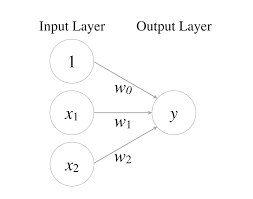

In [2]:
Image("../data/nnlogic.png")

Here we have a 2-layer NN, which is effectively a logistic regression model. The input layer is X and output layer is a single node y. The connections from the input layer to the output layer represent the weights that are to be 'learnt', and represented as a matrix W such that sigmoid(W*X) = y

So a 3-Layer NN with a h-neuron hidden layer would essentially be h ~logistic regressions of the input times y ~logistic regressions of the hidden layer. So there would be x*h + h*w weights to be learnt.

## Forward Pass

The computation of the output layer by composing functions through each hidden layer is called forwards propagation. These functions are called 'activations' and are non-linear in nature. Let's say we have an input feature vector X, a single hidden layer witha sigmoid activation and an output layer with a sigmoid activation.

A forward-pass is then given by:

$ Y' = \sigma( W_{2} \cdot  ( \sigma( W_{1} \cdot X)))$

Where $W_{1}$ and $W_{2}$ are the weights/parameters to be learnt, $X$ is the input vector and $Y'$ is the output vector of the NN 

## Back-Propagation

Remember how we optimised the model in logistic regression? We used the partial differentials of the Cost function w.r.t the weight we were trying to optimize. Same concept, but because we have a composition of functions, we use the chain rule. So let's say cost function $J(x,W_{1},W_{2}, Y) = f( g(x,W_{1}),W_{2},Y) $. 
Then $  \frac{\partial J}{\partial W_{1}} = \frac{\partial f}{\partial g} \cdot \frac{\partial g}{\partial W_{1}} $

The optimising step would then be $ W_{1} \rightarrow W_{1} - \alpha \cdot \frac{\partial J}{\partial W_{1}}$

## In order to get a better grasp of how NNs work, let's build one from scratch using numpy and python

This tutorial uses python classes in order to build a kind of NN-library. This is to help us breakdown the different components that go into a NN and then be able to build different architectures of NN more easily. 

This also allows us to peek into the inner workings of the NN since we can print the weights between any two layers to understand what is happening there. 

You are required to complete the code where it says ''' INSERT CODE HERE '''

It is advised to run 'unit' tests on each block you finish, where possible, by perhaps using a random array.

##### Note: The dimensioning of data is as follows: nxm, n =number of features, m = number of examples. This is the transposed version of what was being used for the previous assignments.

#### Some of the links also provide code. This code is usually not compatible with how our code is structured. It is recommended to just use these links for the derivation, formulas and concepts.

### A quick primer on python objects:

In [3]:
class Object:                    #This is a class, it can have 'members' that are functions or data
    def __init__(self,x):          # the __init__ function initialises the class Object whenever a object is declared
        self.A = x               # here, a data member A (accessed as self.A) is assigned x whenever an object is created
    def mem_function(self,X):    # this is a member function, it can access the class's data and use external parameters
        self.B = self.A+X        # here another data member is created and assigned a value
        
obj = Object(2)                  # here an Object object is created as obj. Here, Object(2) is 
                                 # basically passing 2 to the __init__ function of the object
print("object", obj)
print("it's a Value", obj.A)
obj.mem_function(3)              # here the member function is called using <class_name>.<functoin_name>, 
                                 # self is not passed as a parameter, the object does this implicitly.
obj.B                            # this is how the object's data can be accessed

object <__main__.Object object at 0x7f906807a220>
it's a Value 2


5

# Layout of the Assignment

We will be building the NN(s) using objects in order to make Part C and Part D quicker and simpler.
The NN(s) we will build are classifiers. We have two main datasets:
1. a binary classification problem (same as in Logistic Regression assignment)
2. a handwritten digit classification problem called MNIST

In order to be able to predict the class, we will use one-hot representation of the target data. This allows the NN to output a probability distribution of which class the particular datapoint might belong to.

The functionality of the NN(s) we will build is as follows:

We have an input dataset, $X$, of shape $(n,m)$, With $n=$ number of features and $m =$ number of examples or batch-size.

The NN outputs a probability distribution, $H$, with shape $(n_{class},m)$ of the classes to which each example/datapoint belongs.

We have a fixed number of 'layers' between $X$ and $H$, with each $l^{th}$ 'layer' having weights $W_{l}$, and a bias $B_{l}$.

Each $l^{th}$ 'layer' has an input vector $A_{l-1}$, a linear transformation : ($W \cdot A_{l-1} + B_{l}$) of A0 resulting in vector $Z_{l}$ and an activation function activation($Z_{l}$) which activates on $Z_{l}$ to give a vector $A_{l}$

For the first layer, $A_{l-1}$ = X, and for the last layer $A_{l}$ = $H$, the output vector or 'hypothesis'

#### Note: The output of the NN will be a probability distribution when Softmax is used as output activation. 

In order to prevent code repetition, we define a class Layer and this will allow us to stack several layers with only a few lines.


We first define helper functions that will help us load and process the dataset. 

Next, we define a metric to assess the performance of the models we will use later.

We then define activation functions as classes, with each activation function having an activate() and diff() member fucntion. This way, when we need to find sigmoid(Z), we call sigmoid.activate(Z) and when we need to find $\frac{\partial Sigmoid(Z)}{\partial Z}$, we call sigmoid.diff(Z)



In [4]:
import numpy as np
import struct
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output

### Data Preprocessing

##### Remember to change paths of data files and image files.

The below functions are trivial and can be skipped, unless, you want to come up with a cleaner way to do them ;)

In [5]:
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)
    
def flatten_imgs(X):
    n_img, h, w = np.shape(X)
    size_arr = h*w
    return np.reshape(X,(n_img,size_arr))

### One hot encoding 

One hot encoding is basically representing a class as a boolean vector: e.g if we have 3 classes (let's say classes 1,2,3 ) and we want to represent class '1'. We would do this as [1 0 0]$^{T}$. Class '2' would be [0 1 0]$^{T}$ and so on.. 

One hot encoding allows us to output a probability distribution vector [p1 p2 p3]$^{T}$ such that these probabilities represent the likelihood of the particular class. So a vector [0.9 0.02 0.08]$^{T}$ would mean that the output represents class 1 with a 0.9 probability

one_hot() should convert a 1xm numpy array to an nxm numpy array, where n is the number of class (n_class)

In [6]:
def one_hot(Y,n_class):
    #accept a (1xm) 'label' numpy-array, number of classes  
    #and return a nxm 'one-hot' numpy-array, where n=number of classes 
    O = np.identity(n_class)[Y.astype(int).reshape(-1)]
    
    return O.T

In [7]:
#Test
Y = np.array([[0,1,2,3,4]])
n_class = 5
O = one_hot(Y,n_class)
print(O)
# Should output a matrix equivalent to a 5x5 identity matrix

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


It is useful to have the inverse encoding from one-hot representation. This is the reverse of the one_hot function. So an array of one_hot encoded vectors is passed as parameter and the corresponding label array is returned. 

#### This can be used to convert our output probability distributions of a batch of data points to the corresponding label array. One way to do this would be to find the index of the maximum element of each vector and use that as the label.



In [8]:
def inv_one_hot(O):
    n_class, length = np.shape(O)
    
    Y = np.zeros((1,length))
    
    for i in range(length):
        j = np.argmax(O[:,i])
        Y[0,i] = j
    
    return Y

In [9]:
#unit test

inv_one_hot(O)

#Should output array array([[0., 1., 2., 3., 4.]]) if O is 5x5 identity matrix

array([[0., 1., 2., 3., 4.]])

## Normalization

Neural networks can quickly get messy if the input data is not normalized. You could try implementing the NN without normalizing the data and find out how it affects the performance.

There is one common way of normalizing data, namely by computing the mean $\mu$ and standard devitation $\sigma$.

$\mu = \frac{1}{M}\sum_{m=0}^{M-1} X_m$ $\displaystyle ~~~~\sigma = \sqrt{\frac{1}{M}\sum_{m=0}^{M-1} (X_m -\mu)^2}$

and then defining,

$Y_m = \frac{X_m - \mu}{\sigma}$  $~~~~ m = 0, \ldots, M-1$.

In this case the new data points $Y_m$ are centered around value $0$ with a spread $1$.

Here M is the number of examples i.e the number of columns in X. 
So mean = vector of mean of each row
std = vector of std of each row

If using numpy mean and std functions, specify the axis and remember to pass keepdims=True to maintain the shape of the mean and std vectors at nx1

In [10]:
def normalize(X):
    mean = np.mean(X,axis=1,keepdims=True)
    std =  np.std(X,axis=1,keepdims=True)
    N_X = (X-mean)/(std)
    
    return N_X

## Metrics
In order to effectively measure the performance of our model we can define a 'metric'. Here we use a straight-forward 'right or not' method. This returns a [0,1] value indicating the accuracy of the model. This will later be passed as 'metric' in the train() function, so remember to replace metric with model_accuracy when calling train.

In [11]:
def model_accuracy(H,Y):
    # Y has to be one-hot matrix
    # H can be either one hot or softmax output.
    n = np.shape(H)[1]
    err = 0
    O = inv_one_hot(H)
    L = inv_one_hot(Y)
    for i in range(n):
        if O[0,i]!=L[0,i]:
            err += 1
    accuracy = (1 - err/n)
    
    return accuracy

## Activation Functions

Each node except those in the input layer represents an activation function, which applies a 'non-linearity' to its input parameter.

ML Researchers have empirically found several different activation functions to work with their respective pros and cons. Listed below are the most popular.
Softmax is a unique activation function in that it is used in multiclass classification i.e for categorical data.

For some more comprehension: https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html

|Activation|Equation|
|----|---------|
|<img width=50/>|<img width=100/>|
|Sigmoid| $ \sigma(x) = \frac{1}{1+e^{-x}} $ |
| Tanh | $tanh(x)$ |
| ReLu | $ max(0,x)$    |
| Softmax| $ \frac{e^{x_{i}}}{\sum e^{x_{i}}} $ |

In [12]:
class sigmoid:
    def activate(self,Z):
        #compute A = sigmoid(Z), Z is an nxm numpy array, A should also be an nxm numpy array
        A = (1 + np.exp(-Z))**-1
        
        return A
    
    def diff(self,Z):
        #compute dA_dZ = differential of sigmoid w.r.t Z 
        
        #code provided below, just try to understand what dA_dZ is conceptually
        #dA_dZ = np.multiply(self.activate(Z),(1-self.activate(Z)))
        dA_dZ = self.activate(Z) * (1 - self.activate(Z))
        
        return dA_dZ
    
class relu:
    def activate(self,Z):
        #compute A = relu(Z), Z is an nxm numpy array, A should also be an nxm numpy array
        A = (Z > 0) * Z
        
        return A
    
    def diff(self,Z):
        #compute dA_dZ = differential of relu w.r.t Z 
        
        #code provided below, just try to understand what dA_dZ is conceptually
        #dA_dZ = 1*(Z>0)
        dA_dZ = (Z > 0) * 1
        
        return dA_dZ

class tanh:
    def activate(self,Z):
        #compute A = tanh(Z), Z is an nxm numpy array, A should also be an nxm numpy array
        #numpy has an inbuilt tanh function, you can just call that
        A = np.tanh(Z)
        
        return A

    def diff(self,Z):
        #compute dA_dZ = differential of tanh w.r.t Z 
        
        #code provided below, just try to understand what dA_dZ is conceptually
        #dA_dZ = 1 - (np.multiply(self.activate(Z),self.activate(Z)))
        dA_dZ = 1 - (self.activate(Z)**2)
        
        return dA_dZ

    
# Let this be
class softmax:
    def activate(self,Z):
        e_Z = np.exp(Z- np.max(Z,axis=0))
        A = e_Z / e_Z.sum(axis=0)
        
        return A
    
# Just for formality. Not recommended to be used. 
# w.r.t Z is almost never needed since we compute C.E loss derivative w.r.t Z directly viz  H-Y
    def diff(self,Z):
        sftmx = self.activate(Z)
        a = np.einsum('ij,jk->ijk',np.eye(sftmx.shape[0]),sftmx)
        b = np.einsum('ij,kj->ikj',sftmx,sftmx)
        dH_dZ = a - b
        return dH_dZ


In [13]:
#unit test
# You can try sigmoid(), relu(),tanh() etc here.
activation = sigmoid()

Z = np.array([[-1,2,3]]).T

print("activation(Z)=\n",activation.activate(Z))
#should return a 3x1 array of corresponding activation values.
print("\ndA/dZ = \n",activation.diff(Z))
#should return a 3x1 array of corresponding differential values

activation(Z)=
 [[0.26894142]
 [0.88079708]
 [0.95257413]]

dA/dZ = 
 [[0.19661193]
 [0.10499359]
 [0.04517666]]


## Loss Functions

Loss functions or 'Cost functions' are what are to be minimised. They act as a proxy of the performance of the NN. 

For more comprehension: https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html

Up to now we discussed binary classification. Suppose we have three classes; the function one_hot generates a vector $y_0=[1,0,0]$ for class 0, $y_1=[0,1,0]$ for class 1 and $y_2=[0,0,1]$ for class 2 for each data point.

Our network gives for each data point three probabilities: $p_0$ for that point to be type $0$, $p_1$ for $1$, $p_2$ for $2$. 

Next consider, again for any point point the quantity
$\displaystyle - y_0 \ln(p_0) - y_1 \ln(p_1) - y_2 \ln(p_2)$.
Now assume that our data point is in class $1$ but has a small value for $p_1$. Then the only non-zero term $- y_1 \ln(p_1)$ becomes large, just as we have seen before in binary classification.

Then summing over all data points and dividing by the number of data points gives our cost function.

Note 1: $H$ is the output of the network, which in this case is the probability distribution of the classes.
Note 2: The differential of the Loss function we need is with respect to $Z$, so using the chain rule for partial derivatives: $\frac{\partial L}{\partial Z} = \frac{\partial L}{\partial H} \cdot \frac{\partial H}{\partial Z}  $

For a neat explanation of how to derive the CE_Loss derivative w.r.t $Z$ look at: https://deepnotes.io/softmax-crossentropy

In [14]:
class CE_loss:
    def get_loss(self,H,Y):
        # H,Y are both nxm numpy arrays. L is a single value that represents the loss of the batch (size m)
        L = - np.sum(Y * np.log(H)) / Y.shape[0]

        return L
    
    def diff(self,H,Y):
        #Compute dL_dZ = diff(Cross_Entropy_Loss(H,Y) w.r.t Z)        
        
        n = Y.shape[0]
        #code provided below, just try to understand what dA_dZ is conceptually
        #dL_dZ = 1/n*(H-Y) 
        dL_dZ = 1/n * (H - Y)
        
        return dL_dZ

In [15]:
#unit test
H = np.array([[0.1,0.1,0.8]]).T
Y = np.array([[0,0,1]]).T
loss = CE_loss()

print("loss=",loss.get_loss(H,Y))
print("dL/dZ=",loss.diff(H,Y))

#should give one value for loss, and a nx1 array of corresponding differentials for diff

loss= 0.07438118377140324
dL/dZ= [[ 0.03333333]
 [ 0.03333333]
 [-0.06666667]]


### The definition of the optimization problem.

A neural net consists of layers of nodes. In its simplest form such a network can be described as follows.
- One data point, $X$, is input for the first layer. 
- The output of layer $k-1$ is input for layer $k$. 
- The weight matrix $W_{k}$ that linearly transforms output from layer $k-1$ is of size $n_{k} \times n_{k-1}$. Here $n_m$ is the number of nodes in layer $m$. Moreover the bias of this layer, $b(k)$, is an $n_{k}$ vector.

In formulas
- $Z = W_{k} \cdot A_{k} + B_{k}$
followed by
- $A_{k+1} = g_{k}(Z)$, with $g_{k}$ the activation of layer $k$.

The output of the network is the data on the last layer. For a classification problem the output of the current network (i.e., with these weights) gives the probability of that data being in class $c$, $c=1, \ldots, C$.

**The problem is: for which entries in matrix $W(k)$ and in vector $b(k)$, does the network 
work the best as possible.** 

Note that this can be (is) a huge optimization problem.

### Weight Initialization

Initialization of the weights of a neural network can affect its performance. 
Empirically, it was found that each activation function has its own 'optimal' initialization

Initializations taken from : https://medium.com/usf-msds/deep-learning-best-practices-1-weight-initialization-14e5c0295b94

In [16]:
def init_theta(n1,n2,activation):
    #n1 = number of nodes in prev layer (input)
    #n2 = number of nodes in next layer (output)
    #activation is the class of activation, this is used to select the initialization method. 
    if activation in [sigmoid,softmax]:
        M = np.random.randn(n2,n1)*np.sqrt(2./n1)
    elif activation in [relu] :
        M = np.random.randn(n2,n1)*np.sqrt(1./n1)
    elif activation == tanh:
        M = np.random.randn(n2,n1)*np.sqrt(1./(n1+n2))
    else:
        M = np.random.randn(n2,n1)
    return M

## Model

The model/ NN will be a class. An example 3 layer NN is as follows:

    class NN_model:
        
        def __init__(self, X_size, Y_size, lossfn):
            self.L1 = layer(X_size, num_nodes1, relu)
            self.L2 = layer(num_nodes1, num_nodes2, relu)        
            self.L3 = layer(num_nodes2, Y_size, softmax)
            self.lossfn = lossfn()
        
        def f_pass(self, X):
            A1 = self.L1.forward(X)
            A2 = self.L2.forward(A1)
            A3 = self.L3.forward(A2)
            self.H = A3
            return self.H

        def back_prop(self,X,Y, batch_size):
            m = batch_size
            
            self.loss = self.lossfn.get_loss(self.H,Y)
            dL_dZ = self.lossfn.diff(self.H,Y)
            
            self.L3.out_grad(dL_dZ, self.L2.A, m)
            self.L2.grad(self.L3.dZ, self.L3.W, self.L1.A, m)
            self.L1.grad(self.L2.dZ, self.L2.W, X, m)

        def optim(self, lr):
            self.L1.step(lr)
            self.L2.step(lr)
            self.L3.step(lr)
            
The f_pass() function does one forward pass through the network and outputs the Hypothesis vector $H$

The back_prop() function performs back propagation through the network and stores the gradients of $W$ and $B$ for each layer.

optim() updates the $W$ and $B$ of each layer.

This is where the layer class is used. Each layer of the NN is an object of the class Layer, which we will describe next, and therefore, we can easily stack a bunch of layers with a few lines of code. 

## A Layer of neurons

Recall that each layer has a weight matrix and a bias vector associated with it.
During forward pass, the weights and bias are used in computing $Z$ of input vector $A_{l-1}$ and subsequently activations $A_{l}$ for the layer

```A_prev``` means $A_{l-1}$ was $A0$ in the previous version of the assigment

```dL_dZ_next``` means $\frac{ \partial L}{\partial Z_{l+1}}$  was dZ in function parameter in the previous version of the assignment

We design the layer class as follows:

Layer has a forward() function that computes $Z_{l} = W \cdot A_{l-1} + B$ and then $A_{l}(Z_{l}) = activation(Z_{l})$

`grad()` is used to compute the gradient of $W_{l}$, $dW = \frac {\partial L}{\partial W_{l}} $  and that of $B_{l}, dB = \frac {\partial L}{\partial B_{l}} $ given $\frac {\partial L}{\partial Z_{l+1}}$

`out_grad()` is used to compute the gradient of $W_{l}$, $dW = \frac {\partial L}{\partial W_{l}} $  and that of $B_{l}, dB = \frac {\partial L}{\partial B_{l}} $ as well, but only when the layer is the output layer with the final activation. So, dZ in this case is the differential of the loss function w.r.t $Z_{l}$, so `out_grad` is given $ dZ =  \frac {\partial L}{\partial Z_{l}} $ as parameter

The network with k layers would look like this.

$X$ -> [$Z_{1}(X,W_{1},B_{1})$ -> $A_{1}(Z_{1})$ ] -> [$Z_{2}(A_{1},W_{2},B_{2})$ -> $A_{2}(Z_{2})$] -> ... -> [$Z_{k}(A_{k-1},W_{k},B_{k})$ ->$ A_{k}(Z_{k})$] -> $L(A_{k},Y)$

Where $L()$ is the loss function and Y is the label or target vector

The whole backpropagation of the network, starting from the last $k^{th}$ layer would be as such:

$dW_{k} = \frac {\partial L}{\partial A_{k}} \cdot \frac {\partial A_{k}}{\partial Z_{k}} \cdot \frac {\partial Z_{k}}{\partial W_{k}} $

$dB_{k} = \frac {\partial L}{\partial A_{k}} \cdot \frac {\partial A_{k}}{\partial Z_{k}} \cdot \frac {\partial Z_{k}}{\partial B_{k}} $

$dW_{k-1} = \frac {\partial L}{\partial A_{k}} \cdot \frac {\partial A_{k}}{\partial Z_{k}} \cdot \frac {\partial Z_{k}}{\partial A_{k-1}}  \cdot \frac {\partial A_{k-1}}{\partial Z_{k-1}} \cdot \frac {\partial Z_{k-1}}{\partial W_{k-1}} $

$dB_{k-1} =  \frac {\partial L}{\partial A_{k}} \cdot \frac {\partial A_{k}}{\partial Z_{k}} \cdot \frac {\partial Z_{k}}{\partial A_{k-1}} \cdot \frac {\partial A_{k-1}}{\partial Z_{k-1}} \cdot \frac {\partial Z_{k-1}}{\partial B_{k-1}}$

and so on. 


This can be made modular so we take one layer, let's say the $l^{th}$ layer , that looks like:

$A_{l-1}$ -> [$ Z_{l}(A_{l-1},W_{l},B_{l})$ -> $A_{l}(Z_{l})$ ] -> $Z_{l+1} $

Therefore for this layer's part in backpropagation,we have:

#### If the layer is not the last layer:

$dA_{l} = \frac {\partial L}{\partial A_{l}} = \frac {\partial L}{\partial Z_{l+1}} \cdot W_{l} $

This is because there is at least one layer next to the current layer with $\frac {\partial L}{\partial Z_{l+1}}$

$dZ_{l} = \frac {\partial L}{\partial A_{l}} \cdot \frac {\partial A_{l}}{\partial Z_{l}} $

$dW_{l} = \frac {\partial L}{\partial A_{l}} \cdot \frac {\partial A_{l}}{\partial Z_{l}} \cdot \frac {\partial Z_{l}}{\partial W_{l}} $

$dB_{l} = \frac {\partial L}{\partial A_{l}} \cdot \frac {\partial A_{l}}{\partial Z_{l}} \cdot \frac {\partial Z_{l}}{\partial B_{l}}$

These will be computed in grad()

#### If the layer is the last layer $(k^{th})$:

$dA_{k} = \frac {\partial L}{\partial A_{k}} $
$dZ_{k} = \frac {\partial L}{\partial A_{k}} \cdot \frac {\partial A_{k}}{\partial Z_{k}} $

In the case of using softmax as the output activation and `CE_loss` as the loss function, $dZ_{k} = \frac{1}{n}(A_{k} - Y) = \frac{1}{n}(H - Y)$, where $A_k = H$ as in hypothesis, and n is the number of classes. It is recommended for you to derive this result in order to be able to understand it.

$dW_{k} = \frac {\partial L}{\partial A_{k}} \cdot \frac {\partial A_{k}}{\partial Z_{k}} \cdot \frac {\partial Z_{k}}{\partial W_{k}} $

$dB_{k} = \frac {\partial L}{\partial A_{k}} \cdot \frac {\partial A_{k}}{\partial Z_{k}} \cdot \frac {\partial Z_{k}}{\partial B_{k}}$

This is when `out_grad()` is used

#### In order to update the W and B of the Layer, we use step()
Since each layer has its own W and B matrices, and we store dW and dB, we can update W and B for each matrix as

$W = W - \text{learning_rate} \cdot dW$

$B = B - \text{learning_rate} \cdot dB$

In [17]:
class layer:
    def __init__(self, n_prev, n_next, activation):
        #Each layer object has  W, B and activation()
        self.W = init_theta(n_prev, n_next, activation)
        self.B = init_theta(1, n_next, activation)
        self.activation = activation()
        
    def forward(self, A_prev):
        #A layer first computes Z = W.A_prev + B and then A = activation(Z)
        #Compute Z, remember this class has a W,B and activation(), and how to call member functions 
        #and member functions of member objects. Also remember to use matrix operations for the same.  
        self.Z = self.W @ A_prev + self.B
        self.A = self.activation.activate(self.Z)
        return self.A
    
    def grad(self, dL_dZ_next, W_next, A_prev, m):
        #Compute dL_dA,
        # dL/dZ_next * dZ_next/dA = dL/dA -> eq. 6.21
        dL_dA = W_next.T @ dL_dZ_next
        
        #Compute dA_dZ i.e the differential of this layer's activation w.r.t this layer's Z
        dA_dZ = self.activation.diff(self.Z)
        
        #Compute dZ i.e dL_dZ of this layer. 
        self.dZ = dL_dA * dA_dZ
        
        #Compute dW and dB, with the same shape as W and B respectively
        self.dW = 1/m * self.dZ @ A_prev.T
        self.dB = 1/m * np.sum(self.dZ, axis=1, keepdims=True)
    
    def out_grad(self, dL_dZ, A_prev, m):
        self.dZ = dL_dZ
        self.dW = (1./m)*(np.dot(self.dZ, A_prev.T))
        self.dB = (1./m)*(np.sum(self.dZ, axis=1, keepdims=True))
        
    def step(self, lr):
        # lr stands for learning rate.
        #Compute the step updates on W and B, using this layer's dW, dB, and lr.
        self.W -= lr*self.dW
        self.B -= lr*self.dB

## Optimizer

NNs can be quite tricky to optimize because of the sheer number of parameters. Optimization can quickly get out of hand. A mini-batch gradient descent method is empirically shown to perform best and with decent stability. This is also called stochastic gradient descent interchangeably.

There are modifications to SGD that can be done such as Momentum, RMS_Prop, Adam etc. which are not included for sake of simplicity. This works well enough for relatively shallow networks. When Deep NNs are used, these more advanced optimizers become handy.

In [18]:
def SGD(batch_size,X,Y,model,lr=0.001):
    m = np.shape(X)[1]
    
    for i in range(0,m,batch_size):
        X_batch = X[:,i:i+batch_size]
        Y_batch = Y[:,i:i+batch_size]
        
        #call model's f_pass() on X_batch
        model.f_pass(X_batch)
        
        #call model's back_prop() for X_batch,Y_batch and batch_size
        model.back_prop(X_batch, Y_batch, batch_size)
        
        #call model's optim() for lr
        model.optim(lr)
    
    return model.loss

### Solving the optimization problem: training.

- Take a data point and go through the forward pass. 

- Compute the loss function. This is a function of the actual label $Y$ and predicted label $H$, $f(Y, H)$. It captures how far off our predictions are from the actual target.

- Backward Propagation. In this step, we calculate the gradients of the loss function $f(Y, H)$ with respect to $A$, $W$, and $b$ called $dA$, $dW$ and $dB$. Using these gradients we update the values of the parameters from the last layer to the first.

Repeat these stepsfor $n$ iterations/epochs till we feel we have minimized the loss function, without overfitting the train data (more on this later!)


## Training

The NN is finally trained for n_epochs and a plot of the training accuracy and test accuracy over n_epochs is displayed. This helps determine overfit/underfit and tuning of the hyperparameters.

Nothing fancy to be done here. We are just calling SGD on our model using the hyperparameters we pass as parameters. We are appyling inv_one_hot transformations in order to be able to calculate the metric we defined earlier

In [19]:
def train(model, X, Y, X_test, Y_test, metric, n_epochs=100, batch_size=4, lr=0.01, lr_decay=1):
    data_size = X.shape[1]
    for e in range(n_epochs):
        #shuffle dataset
        # shuffling helps remove possible serial-relations between data, and reduces 'memorisation'
        np.random.seed(138)
        shuffle_index = np.random.permutation(data_size)
        X, Y = X[:,shuffle_index], Y[:,shuffle_index]

        #SGD
        loss = SGD(batch_size,X,Y,model,lr)
        
        #decay helps decrease the size of steps over time, improving stability and convergence
        lr = lr*lr_decay
        
        #train accuracy
        H = model.f_pass(X)
        tr_acc = metric(H,Y)
        
        #test accuracy
        H = model.f_pass(X_test)
        acc = metric(H,Y_test)

        #plot train accuracy and test accuracy vs epochs
        plt.plot(e,tr_acc, 'bo')
        plt.plot(e,acc,'ro')
        clear_output()
        print(f"epoch:{e+1}/{n_epochs} | Loss:{loss:.4f} | \
            Train Accuracy: {tr_acc:.4f} | Test_Accuracy:{acc:.4f}")
        
    #plt.legend()
    # Plot these points double so that we can label them
    plt.plot(e,tr_acc, 'bo', label="Training acc.")
    plt.plot(e,acc,'ro', label="Test acc.")
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.legend()
    plt.show()

### Review of what we have done so far:

1. Defined Class Layer and we can use objects of this class to stack multiple layers and build a NN.
2. Defined Activation functions and loss function as classes. While creating objects of the class Layer in the NN, we can select which Activation we want and what loss we will use for the NN
3. Defined function SGD() as the optimizer 
4. Defined function Train() that executes the training on the dataset 


### What we need further in order to build the NN:

1. Load the dataset for the classification problem we want to solve
2. Define a model using the template presented before (under 'Model')
3. Specify the values of the Hyperparameters
4. Call train() with relevant parameters

# Part A: Logistic Regression as a NN

Let's repeat the logistic regression exercise on ex2data1.csv as done in week 2, this time based on a NN.


### Loading data, and partitioning train and test set

If you want to find out what happens when the input is not normalized, comment out the normalize function calls

In [20]:
# Simple Train/test split seems to cause a high error - Shuffle df for better results
import pandas as pd

df = pd.read_csv('../data/ex2data1.csv')

A2 = df.values.T
X1 = A2[0:2,0:-10]
X2 = normalize(X1)
Y1 = A2[2:3,0:-10]
Y2 = one_hot(Y1,2)
X1_test = A2[0:2,-10:]
X2_test = normalize(X1_test)
Y1_test = A2[2:3,-10:]
Y2_test = one_hot(Y1_test,2)

In [21]:
def plotData(data, label_x, label_y, label_pos, label_neg, axes=None):
    if axes == None:
        axes = plt.gca()
    neg = data[:,2] == 0
    pos = data[:,2] == 1
    axes.scatter(data[pos][:,0], data[pos][:,1], marker='+', c='k', s=60, linewidth=2, label=label_pos)
    axes.scatter(data[neg][:,0], data[neg][:,1], c='y', s=60, label=label_neg)
    axes.set_xlabel(label_x)
    axes.set_ylabel(label_y)
    axes.legend(frameon= True, fancybox = True);

## Below we define the Logistic regression model as a NN

In [22]:
class Logistic:
    def __init__(self, X_size, Y_size, lossfn):
        self.regressor = layer(X_size, Y_size, softmax)
        self.lossfn = lossfn()
        
    def f_pass(self, X):
        #Compute the output of the NN using this model's regressor layer's forward()
        self.H = self.regressor.forward(X)
        return self.H
    
    def back_prop(self, X, Y, batch_size):
        m = batch_size
        
        #Compute loss of model using this model's lossfn's get_loss()
        self.loss = self.lossfn.get_loss(self.H, Y)
        
        #Compute dL_dz using this model's lossfn's diff()
        dL_dZ = self.lossfn.diff(self.H, Y)
        
        #We call out_grad() to calculate the gradients and store them. 
        self.regressor.out_grad(dL_dZ, X, m)
    
    def optim(self, lr):
        #Call this model's 
        self.regressor.step(lr)

In [23]:
n_in = np.shape(X2)[0]
n_out = np.shape(Y2)[0]

# log_reg is the object of the class Logistic, which is a 'model'
log_reg = Logistic(n_in,n_out,CE_loss)

## Hyperparameters

Parameters that define the training and the NN are called Hyperparameters ( so Meta!)
These include the learning rate, the batch size for the SGD, the decay in the learning rate etc

In [24]:
#Hyperparameters feel free to tweak these!

#batch_size
#lies in [1,X.shape[1]], preferably powers of 2
# 1 -> stochastic descent
# X.shape[1] -> batch descent
batch_size = 16

#learning rate
lr = 0.01

n_epochs = 100

#learning rate decay parameter, lies in [0,1]
lr_decay = 0.99

epoch:100/100 | Loss:2.2388 |             Train Accuracy: 0.8778 | Test_Accuracy:0.9000


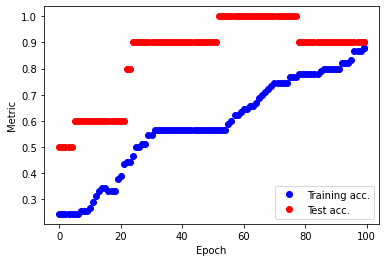

In [25]:
#The following will be passed to train() as parameters
# training data : X2, Y2
# test data : X2_test and Y2_test
# metric : model_accuracy
# model : log_ref

#call train() with parameters 
train(log_reg, X2, Y2, X2_test, Y2_test, model_accuracy, n_epochs, batch_size, lr, lr_decay)

#The plot helps visualise train accuracy and test accuracy over epochs, and therefore check how the model is 
#fitting the train and test data

In [26]:
#Here we are using log_reg to infer H from X2, and convert it to a label vector representation H2. 
#A3 combines H2 and A3 vertically so that we can pass it to plotData()

H = log_reg.f_pass(X2)
H2 = inv_one_hot(H)
A3 = np.vstack([X1,H2])

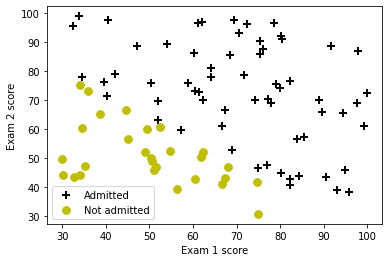

In [27]:
plotData(A3.T, 'Exam 1 score', 'Exam 2 score', 'Admitted', 'Not admitted')

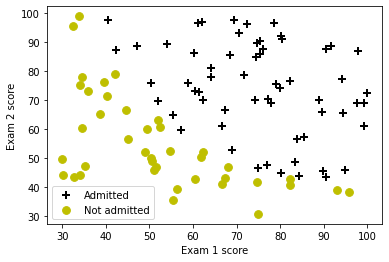

In [28]:
plotData(A2.T, 'Exam 1 score', 'Exam 2 score', 'Admitted', 'Not admitted')

# Part B: 3 Layers 

Now we add two layers to this Logistic-Regression-like NN and try to get similar or better results.

In [29]:
class HL_net:
    def __init__(self, X_size, Y_size, lossfn):
        self.L1 = layer(X_size, 100, relu)
        self.L2 = layer(100, 20, relu)        
        self.L3 = layer(20, Y_size, softmax)
        self.lossfn = lossfn()
        
    def f_pass(self, X):
        #Compute the activation of each layer using the respective layer's forward()
        layers = (self.L1, self.L2, self.L3)
        A = X

        for i in layers:
            A = i.forward(A)

        self.H = A
        return self.H
    
    def back_prop(self,X,Y, batch_size):
        m = batch_size
        
        #use the model's lossfn's get_loss() to find the loss of the model
        self.loss = self.lossfn.get_loss(self.H, Y)
        
        #use the model's lossfn's diff() to find dL_dZ
        dL_dZ = self.lossfn.diff(self.H, Y)
        
        #Call out_grad() for the last layer. For a 3-layer NN, example is provided below:
        #self.L3.out_grad(dL_dZ, self.L2.A, m)
        self.L3.out_grad(dL_dZ, self.L2.A, m)
        
        # call each layer's grad() from the penultimate layer to the first layer to perform back_prop
        self.L2.grad(self.L3.dZ, self.L3.W, self.L1.A, m)
        self.L1.grad(self.L2.dZ, self.L2.W, X, m)
    
    def optim(self, lr):
        #call each layer's step() to update their respective W and B
        layers = (self.L1, self.L2, self.L3)
        for i in layers:
            i.step(lr)

In [30]:
n_in = np.shape(X2)[0]
n_out = np.shape(Y2)[0]

#This is the new 'model', so bin_class will be passed to train()
bin_clas = HL_net(n_in,n_out,CE_loss)

In [31]:
#Hyperparameters
n_epochs = 200
lr = 0.01
lr_decay = 0.99
batch_size = 16 # mini-batch gradient descent here

epoch:200/200 | Loss:0.4637 |             Train Accuracy: 0.9556 | Test_Accuracy:0.6000


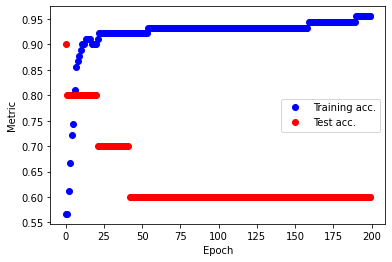

In [32]:
# training data : X2, Y2
# test data : X2_test and Y2_test
# metric : model_accuracy
# model : bin_clas

#call train() with parameters 
train(bin_clas, X2, Y2, X2_test, Y2_test, model_accuracy, n_epochs, batch_size, lr, lr_decay)

#The plot helps visualise train accuracy and test accuracy over epochs, and therefore check how the model is 
#fitting the train and test data

See how training accuracy is way higher than test accuracy?

This is mainly because of overfitting, and partially because we have such a small dataset over which we repeat training.

The act of stopping training at a relatively high training accuracy such that the test accuracy does not decrease further w.r.t the train accuracy is called early stopping and this controls overfitting.

# Part C: Let's Classify images!

We finally get to define the NN below. We are free to choose the number of hidden layers and the respective sizes, the activation functions for each of these, the loss function etc. This is where the object oriented setup helps.

In [33]:
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

''' CHANGE PATH IN THE BELOW LINE ACCORDING TO YOUR DIRECTORY STRUCTURE'''
X = read_idx('../data/train-images-idx3-ubyte')     
X = flatten_imgs(X)
X = normalize(X)               # Try without this
X = np.transpose(X)

''' CHANGE PATH IN THE BELOW LINE ACCORDING TO YOUR DIRECTORY STRUCTURE'''
Y = read_idx('../data/train-labels-idx1-ubyte')
Y = np.expand_dims(Y, axis=1)
Y = np.transpose(Y)
Y = one_hot(Y,10)

''' CHANGE PATH IN THE BELOW LINE ACCORDING TO YOUR DIRECTORY STRUCTURE'''
X_test = read_idx('../data/t10k-images.idx3-ubyte')
X_test = flatten_imgs(X_test)
X_test = normalize(X_test)     # Try without this
X_test = np.transpose(X_test)

''' CHANGE PATH IN THE BELOW LINE ACCORDING TO YOUR DIRECTORY STRUCTURE'''
Y_test = read_idx('../data/t10k-labels.idx1-ubyte')
Y_test = np.expand_dims(Y_test, axis=1)
Y_test = np.transpose(Y_test)
Y_test = one_hot(Y_test,10)

### Let's visualise what one sample of our dataset looks like

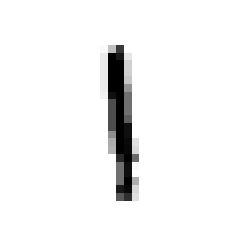

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


(10, 60000)

In [34]:
i = 8
plt.imshow(X[:,i].reshape(28,28), cmap = matplotlib.cm.binary)
plt.axis("off")
plt.show()
print(Y[:,i])
Y.shape

In [35]:
class MNIST_net:
    def __init__(self, X_size, Y_size, lossfn, l_set):
        
        # Build the network. Recommended depth: 2-5 layers. Number of nodes: below 200 preferably.
        # Final activation should be softmax, since each datapoint belongs to only one clas
        
        # Possible code provided below (You could try and tweak this first)
        
        #self.L1 = layer(X_size, 150, relu)
        #self.L2 = layer(150, 50, relu)        
        #self.L3 = layer(50, Y_size, softmax)        
        #self.lossfn = lossfn()
        
        self.layers = [layer(*i) for i in l_set]
        self.lossfn = lossfn()
        
    def f_pass(self, X):
        #call each layer's forward function like we did in HL_net
        A = X
        for l in self.layers:
            A = l.forward(A)
        
        self.H = A
        
        return self.H
    
    def back_prop(self,X,Y, batch_size):
        m = batch_size
        
        #use the model's lossfn's get_loss() to find the loss of the model
        self.loss = self.lossfn.get_loss(self.H, Y)
        
        #use the model's lossfn's diff() to find dL_dZ
        dL_dZ = self.lossfn.diff(self.H, Y)
        
        #Call out_grad() for the last layer. For a 3-layer NN, example is provided below:
        #self.L3.out_grad(dL_dZ, self.L2.A, m)
        self.layers[-1].out_grad(dL_dZ, self.layers[-2].A, m)
        
        # call each layer's grad() from the penultimate layer to the first layer to perform back_prop
        getA = lambda i: self.layers[i].A if i >= 0 else X

        # Unfortunately, we cannot use enumerate here since we need to index the original list,
        # not this sliced one
        for l in self.layers[-2::-1]:
            i = self.layers.index(l)
            l.grad(self.layers[i + 1].dZ, self.layers[i + 1].W, getA(i - 1), m)
        
    def optim(self, lr):
        #call each layer's step() to update their respective W and B
        for l in self.layers:
            l.step(lr)

We create the model below

In [36]:
#Model creation
n_in = np.shape(X)[0]
n_out = np.shape(Y)[0]

l_set = ( \
    (n_in, 150, relu),
    (150, 50, relu),
    (50, n_out, softmax)
)

mnist_net = MNIST_net(n_in,n_out,CE_loss, l_set)

In [37]:
#Hyperparameters feel free to tweak these!

#batch_size
#lies in [1,X.shape[1]], preferably powers of 2
# 1 -> stochastic descent
# X.shape[1] -> batch descent
batch_size = 16

#learning rate
lr = 0.01

n_epochs = 10

#learning rate decay parameter, lies in [0,1]
lr_decay = 0.99

epoch:10/10 | Loss:0.9699 |             Train Accuracy: 0.9573 | Test_Accuracy:0.9547


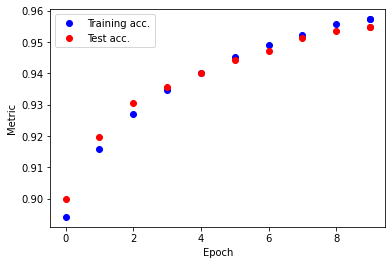

In [38]:
# training data : X, Y
# test data : X_test and Y_test
# metric : model_accuracy
# model : mnist_net

#call train() with parameters 
train(mnist_net, X, Y, X_test, Y_test, model_accuracy, n_epochs, batch_size, lr, lr_decay)


#The plot helps visualise train accuracy and test accuracy over epochs, and therefore check how the model is 
#fitting the train and test data

# Part D: The empirical process of training NNs

We have defined a 3-layer NN to classify handwritten digits.

Play around with the depth of the NN (add more layers), the width of the layers (add more nodes), the hyperparameters, the activation functions and observe the effects these bear on the performance of the NN

In [39]:
from time import perf_counter

epoch:12/12 | Loss:0.0372 |             Train Accuracy: 0.9913 | Test_Accuracy:0.9726


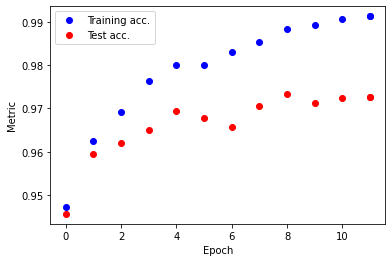

Elapsed time: 132.97272080000005s


In [40]:
n_in = np.shape(X)[0]
n_out = np.shape(Y)[0]

#We create a fresh object of MNIST_net

#l_set = ( \
#    (n_in, 150, relu), \
#    (150, 50, relu), \
#    (50, n_out, softmax) \
#)

#l_set = (\
#    (n_in, 64, relu), \
#    (64, 16, relu),
#    (16, 7, relu),
#    (7, n_out, softmax)
#)

l_set = (\
    (n_in, 64, relu), \
    (64, 16, relu),
    (16, n_out, softmax)
)

mnist_net = MNIST_net(n_in,n_out,CE_loss, l_set)

n_epochs = 12
lr = 0.1
lr_decay = 0.99
batch_size = 16

# training data : X, Y
# test data : X_test and Y_test
# metric : model_accuracy
# model : mnist_net

#call train() with parameters 
start = perf_counter()
train(mnist_net, X, Y, X_test, Y_test, model_accuracy, n_epochs, batch_size, lr, lr_decay)

print(f"Elapsed time: {perf_counter() - start}s")

#The plot helps visualise train accuracy and test accuracy over epochs, and therefore check how the model is 
#fitting the train and test data

Make your observations below:

*These tests were performed using the already given 3-layer network, unless stated otherwise. Each time and accuracy measurement was taken only once.*

Using 1 epoch, `lr = 0.01` and `lr_decay = 0.99`:
- bs=4, time=28.8s, test_acc=0.93
- bs=8, time=25.1s, test_acc=0.92
- bs=16, time=23.6s, test_acc=0.90
- bs=32, time=22.7s, test_acc=0.88
- bs=64, time=22.6s, test_acc=0.82
- bs=256, time=22.1s, test_acc=0.53
- bs=60000, time=23.4s, test_acc=0.10

From these results we can see that optimising the neural network in batches of various sizes can greatly impact the performance. Firstly, the test accuracy decreases with increasing batch size. This means that smaller batch sizes provide decent accuracy in less iterations. However, the downside of smaller batch sizes is an increase in the runtime of an individual epoch. Conversely though, larger batch sizes need more epochs to obtain the same test accuracy. Thus, there exists a batch size for which the highest accuracy is obtained in the least amount of time. Much greater batch sizes seem like bad options: both the runtime in one epoch is increased from smaller batch sizes, and the test accuracy is very poor.

Using 10 epochs, `lr = 0.01` and `lr_decay = 0.99`:
- bs=4, time=274.3s, test_acc=0.97
- bs=16, time=228.6s, test_acc=0.95
- bs=64, time=220.0s, test_acc=0.92

These results confirm what we have previously stated. Of remaining interest then, is which batch size gives the highest accuracy given similar run times. So, running a batch size of four for ten epochs, and a batch size of 16 for twelve epochs yields,
- 10 epochs, bs=4, time=274.3s, test_acc=0.97 (copy of previous result)
- 12 epochs, bs=16, time=276.2s, test_acc=0.95

So, even in this case where the runtimes are roughly matched, the smaller batch size obtained a slightly better testing accuracy in less epochs. However, in my opinion it isn't of massive importance to find the perfect batch size, as long as the pick of batch size is reasonably small ($< 64$ for this data set).

*The remaining experiments will be performed with bs=16 and 5 epochs, unless stated otherwise.*
Next, let us consider the learning rate parameters. Firstly, let us modify `lr`, keeping `lr_decay=0.99`,
- lr=0.005, time=115.5s, test_acc=0.92
- lr=0.01, time=119.9s, test_acc=0.94
- lr=0.05, time=116.4s, test_acc=0.97
- lr=0.1, time=116.5s, test_acc=0.98
- lr=0.25, time=116.6s, test_acc=0.98 (convergence isn't smooth)
- lr=0.75, time=116.4s, test_acc=0.98 (convergence difficult)
- lr=1.5, time=115.0s, test_acc=0.97 (convergence difficult)
- lr=5, time=116.1s, test_acc=0.10 (divergence! finally!)

What we see from these results is that the learning rate is a damping or convergence factor. A larger learning rate means faster convergence, but at the risk of overshooting or even diverging from the result. I must say that I was suprised at how far I needed to push this factor in order to obtain actual divergence. I already saw problems starting at `lr=0.25`, where I saw some overshooting behaviour. However, the learning rate decay factor probably allowed the system to eventually convergence, due to the learning rate decreasing with every iteration. So, a higher learning rate yields higher accuracy in the same run time, if it isn't too large and paired with an appropriate `lr_decay` factor. From its name and its implementation, I can already deduce that `lr_decay` should be inversely proportional to `lr`: small learning rates needn't decay, as the steps per iteration are small enough to eventually become really accurate. Large learning rates on the other hand adjust the weights very rapidly. Without a proper decay, it becomes harder to make small adjustments to the weights to maximise the accuracy.

Even though five epochs are rather limited, let us still see the effect of the `lr_decay` parameter in action.
*The remaining experiments will use `lr=0.1` unless stated otherwise.*
- lr_decay=1, time=116.0s, test_acc=0.9771
- lr_decay=0.995, time=116.2s, test_acc=0.9764
- lr_decay=0.99, time=115.0s, test_acc=0.9767
- lr_decay=0.95, time=116.8s, test_acc=0.9754
- lr_decay=0.9, time=116.2s, test_acc=0.9740
- lr_decay=0.5, time=114.3s, test_acc=0.9672

The results are what we expected. A larger decay implies more iterations for the same accuracy. As our choice for `lr` already proved reasonable, the decay doesn't seem to prevent an overshooting or divergence. However, as previously stated, the impact on the decay is limited with only five epochs.

*The remaining experiments will be performed using `lr_decay=0.99` unless stated otherwise*

Finally, let us adjust the actual neural network, to see if we can improve its performance. I am not going to modify the network a bunch of times to see what the impact will be. Instead, I am going to make a network based on a few assumptions, which I will state below. We'll find out if those assumptions prove to be correct. I am going to use ReLu in all layers except the last (where I will use softmax), because ReLu seems to provide faster convergence.

### Layer 1
This layer will consist of 64 nodes. The hope/assumption is, that clumps of pixels are identified to be the building blocks of the numbers. We don't want too many nodes, as shapes can either be counted multiple times, or this whole assumption of shapes becomes incorrect alltogether.

### Layer 2
This layer will reduce the amount of nodes to 16. The hope is that multiple shapes are combined as some form of puzzle or Lego bricks.

### Layer 3
This layer will consist of only 7 nodes. The reasoning here is to see if we can emulate some kind of "7-segment display", or we can obtain some very general shapes, i.e. top circle, line right, etc.

### Layer 4
This layer will be the output layer, which will be identical to what we used before.

## Results
With the current settings, we obtain a test accuracy of 0.9670 in a time of 50.6s. This is less than the accuracy of 0.9767 of the previous network, but the run time for our network has been less. Increasing to 12 epochs yields a test accuracy of 0.9682 in a time of 121.0s. So, no real improvement. This network seems to converge rather quickly, and become overfitted. Additionally, our convergence using these settings isn't great, as we see some oscillatory behaviour in the test accuracy.

As a last attempt, let us remove the "7-digit display" layer, to see if that layer removes too much information. We will again run 12 epochs to match the run times of previous results. This yields an accuracy of 0.9726 in 120.0s. So, it is a little better, but the convergence is again not great.

From these experiments we see that there are many ways to influence a neural network. Turning a knob somewhere also means influencing another knob somewhere else. This implies that there are many different permutations of hyperparameters and network properties that can all be tuned to provide reasonable results. Optimising these parameters, however, is paramount for obtaining a decent result in a reasonable timeframe.
